run # 1
run # 2


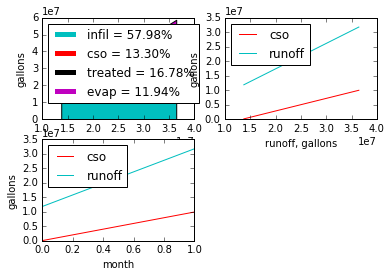

In [1]:
import itertools
from swmm_objects_lid import *
from swmm_read_runoff import *
from subprocess import call
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab
import matplotlib.colors as colors
import sys
from pymongo import MongoClient
from datetime import datetime


def runswmm(start, end):
    (section_names,sections) = read_inp("wingo_sewers_one_outlet.inp")
    model1 = swmm_model('Model1',section_names,sections)
    model1.change(option,'START_DATE','Value', start)
    model1.change(option,'REPORT_START_DATE','Value', start)
    model1.change(option,'END_DATE','Value', end)
    f = open("wingo_sewers_one_outlet.inp",'w')
    model1.output(f)
    f.close()

def get_data():
    runoff_data_file = open("runoff_data", "w")
    runoff_data_file.write("Runoff     precipitation    Total_outflow      CSO_volume     Treated          evaporation      infiltration     hours_cso      Date \n")
    #outflow_data_file = open("outflow_data", "w")
    #hours_data_file = open("hour_data","w")
    dates = ['07/01/2008', '07/10/2008','07/20/2008']# , '10/01/2008', '11/01/2008','12/01/2008', \
    # '01/01/2009', '02/01/2009', '03/01/2009', '04/01/2009', '05/01/2009', '06/01/2009', \
    # '07/01/2009', '08/01/2009', '09/01/2009','10/01/2009', '11/01/2009', '12/01/2009', '01/01/2010',\
    # '02/01/2010', '03/01/2010', '04/01/2010', '05/01/2010', '06/01/2010', '07/01/2010', \
    # '08/01/2010', '09/01/2010','10/01/2010', '11/01/2010', '12/01/2010', '01/01/2011', '02/01/2011', \
    # '03/01/2011', '04/01/2011', '05/01/2011', '06/01/2011', '07/01/2011', '08/01/2011', \
    # '09/01/2011','10/01/2011', '11/01/2011', '12/01/2011', '01/01/2012', '02/01/2012',  \
    # '03/01/2012', '04/01/2012', '05/01/2012', '06/01/2012', '07/01/2012', '08/01/2012', '09/01/2012', \
    # '10/01/2012', '11/01/2012', '12/01/2012', '01/01/2013', '02/01/2013', '03/01/2013', \
    # '04/01/2013', '05/01/2013', '06/01/2013', '07/01/2013', '08/01/2013', '09/01/2013', \
    # '10/01/2013', '11/01/2013', '12/01/2013', '01/01/2014', '02/01/2014', '03/01/2014', \
    # '04/01/2014', '05/01/2014', '06/01/2014']

    months = len(dates)-1
    #will use these to create arrays that will be returned by the function
    data_array = list() #for the array, right now it is a list, will convert to array after loop
    k=0
    for i in range(months):
        month_variables = []
        out_variables = []
        start = dates[i]
        end = dates[i+1]
        k+=1
        runswmm(start, end)
        call(["./swmm5", "wingo_sewers_one_outlet.inp", "C:/Users/Jonathan/Git_repo/SWMMWise/python_runs/runoff_rep.rpt"])#, "C:/Users/Jonathan/Desktop/python_runs/out.out"])
        #out_vals=read_cso("outtest.txt")
        #swmm_data_file.write("%s \n" % (out_vals))\
        print "run # %d" %k
        run_vals=read_runoff("runoff_rep.rpt")
        precip_vals=read_precipitation("runoff_rep.rpt")
        out_vals=read_out_volume("runoff_rep.rpt")
        evap_vals=read_evaporation("runoff_rep.rpt")
        infil_vals=read_infiltration("runoff_rep.rpt")
        times, outflows = read_outflow("runoff_rep.rpt")  #assigns variable to each month's outflow data
        
        out_variables.append(outflows) #convert outflows to string
        month_variables.append(times)
        # converting units
        #325851
        run_vals = float(run_vals)*325851 #convert from acre-ft to gallons
        precip_vals = float(precip_vals)*325851
        out_vals = float(out_vals)*1000000 #convert from gallons*10^6 to gallons
        evap_vals = float(evap_vals)*325851
        infil_vals  = float(infil_vals)*325851

        #calculating treated and cso volume
        cso_flow = 0
        hours = 0
        tot_flow = 0
        max_treatment = 3122*0.05
        for i in out_variables: #out_variables is list within list (though outer list is just one element)
            tot = len(i)
            for j in i:
                if float(j) > max_treatment:  #ratio method
                    tot_flow += float(j)
                    cso = float(j) - max_treatment
                    cso_flow += cso 
                    hours += 1
        tot_volume = tot_flow*900*7.48052 #conver to gallons, and seconds in an hour
        cso_volume = cso_flow*900*7.48052 #for seconds in a hour
            #equiv_rat = cso_volume/tot_volume  #equivalency ratio
        treated_volume = tot_volume - cso_volume
             
             #writing to file
        runoff_data_file.write("%s" % (run_vals))
        runoff_data_file.write("  %s" % (precip_vals))
        runoff_data_file.write(" %s" % (out_vals))
        runoff_data_file.write("  %s" % (cso_volume))
        runoff_data_file.write("  %s" % (treated_volume))
        runoff_data_file.write("  %s" % (evap_vals))
        runoff_data_file.write("  %s" % (infil_vals))
        runoff_data_file.write("  %s" % (hours))
        #runoff_data_file.write("  %s" % (equiv_rat))
        runoff_data_file.write("  %s \n" % (start))
        
        sim_data = [run_vals, precip_vals, out_vals, cso_volume, treated_volume, evap_vals, infil_vals]
        data_array.append(sim_data)
    matr = np.array(data_array) #the data matrix/array
    matr = matr[matr[:,0].argsort()]
    runoff_arr = []
    precip_arr = []
    outflow_arr = []
    cso_arr = []
    treated_arr = []
    evap_arr = []
    infil_arr = []
    for i in matr: 
        runoff_arr.append(i[0])
        precip_arr.append(i[1])
        outflow_arr.append(i[2])
        cso_arr.append(i[3])
        treated_arr.append(i[4])
        evap_arr.append(i[5])
        infil_arr.append(i[6])
    runoff_data_file.close()
    mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
    client = MongoClient(mongoServer)
    db = client.test  # attach to the database named "test"
    # db = client.jcohen4  # attach to the database named "jcohen4"
    # Note: jon has been given access to two databases:  test and jcohen4
    db.authenticate('jcohen4', 'wingohocking', source='jcohen4')  
    authenticationDatabase = "jcohen4"
    balance = [runoff_arr, precip_arr, outflow_arr, cso_arr, treated_arr, evap_arr, infil_arr]

    #sim_results = {'runoff':runoff_arr, 'precip':precip_arr, 'outflow':outflow_arr,\
     #                        'cso':cso_arr, 'treated':treated_arr, 'evap':evap_arr, 'infil':infil_arr}
    sim_results = {'data':balance}
    thisCollection = db['wingo_fourth']    # use (or create, if it doesn't yet exist) a collection named "test1" in the database
    sim_results_id = thisCollection.insert_one(sim_results).inserted_id  # insert the dictionary into the database
    sim_results_id  # display the unique identification code assigned to this dictionary to confirm it was inserted into database
    cursor = db.wingo_fourth.find()
    #for sim_results in cursor:
    #    print sim_results
    #print sim_results_id
    #print thisCollection
    return cursor
 
def plots(arr):
    total = 0 #total water balance
    dat = arr[4]
    dat =  dat['data']
    runoff_arr = dat[0]
    precip_arr = dat[1]
    outflow_arr = dat[2]
    cso_arr = dat[3]
    treated_arr = dat[4]
    evap_arr = dat[5]
    infil_arr = dat[6]
#    for i in arr: 
#        runoff_arr.append(i[0])
#        precip_arr.append(i[1])
#        outflow_arr.append(i[2])
#        cso_arr.append(i[3])
#        treated_arr.append(i[4])
 #       evap_arr.append(i[5])
 #       infil_arr.append(i[6])
    length = 7
    
    #getting total of each value - use these to get percentages
    sum_array = np.array([[float(0)],[float(0)],[float(0)],[float(0)],[float(0)],[float(0)],[float(0)]])
    #for i in arr:
        #print i
        

    percentages = []

    for i in range(0,length): 
        for j in dat[i]:
            sum_array[i] += j
            
    for i in range(3,length):
        total += sum_array[i]
        
    for i in range(3,length):      
            ratio =  (float(sum_array[i])/float(total))*100
            percentages.append(ratio)
   # print percentages
    
    %matplotlib inline
    plt.subplot(2,2,1)
    plt.plot([],[],color='c', label='infil = %.2f%%' % percentages[3], linewidth=5)
    plt.plot([],[],color='r', label='cso = %.2f%%' % percentages[0], linewidth=5)
    plt.plot([],[],color='k', label='treated = %.2f%%' % percentages[1], linewidth=5)
    plt.plot([],[],color='m', label='evap = %.2f%%' % percentages[2], linewidth=5)
    plt.stackplot(runoff_arr, [infil_arr, cso_arr, treated_arr, evap_arr], colors=['c','r','k','m'])
    plt.legend(loc = 'upper left')
    plt.xlabel('runoff, gallons')
    plt.ylabel('gallons')
    #plt.xlim(0,20)

    plt.subplot(2,2,2)
    plt.plot(runoff_arr, cso_arr, color='r', label = 'cso')
    plt.plot(runoff_arr, infil_arr, color='c', label ='runoff')
    plt.xlabel('runoff, gallons')
    plt.ylabel('gallons')
    plt.legend(loc = 'upper left')


    
    plt.subplot(2,2,3)
    plt.plot(range(0,2),cso_arr, color='r', label = 'cso')
    plt.plot(range(0,2),infil_arr, color='c', label = 'runoff')
    plt.xlabel('month')
    plt.ylabel('gallons')
    plt.legend(loc = 'upper left')
    plt.show()
    
   # axes = plt.gca()
   # water_arrays = [infil_arr, cso_arr, treated_arr, evap_arr]
   # colors = ['c','r','k','m']
  #  for i in range(0,3):      
      #  m, b = np.polyfit(runoff_arr, water_arrays[i], 1)
       # plt.stackplot(i, m*i + b, color=colors[i], linewidth='2.0')

    plt.show

    
def main():
    arr = get_data()
    plots(arr)
    
main()

        